In [1]:
!apt-get update
!apt-get install -y libgl1-mesa-glx

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1224 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2942 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [3145 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1424 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1119 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [3102 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-upd

In [2]:
!git clone https://github.com/vislearn/ControlNet-XS

Cloning into 'ControlNet-XS'...
remote: Enumerating objects: 599, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 599 (delta 7), reused 4 (delta 4), pack-reused 583
Receiving objects: 100% (599/599), 94.79 MiB | 4.78 MiB/s, done.
Resolving deltas: 100% (90/90), done.


In [3]:
!pip install -r ControlNet-XS/requirements/pt2.txt -qq
!pip install -e ControlNet-XS -qq

___

Restart kernel here, so newly installed packages are available

___

In [1]:
import scripts.control_utils as cu
import torch
from PIL import Image

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [2]:
path_to_config = 'ControlNet-XS/configs/inference/sdxl/sdxl_encD_canny_48m.yaml'

If this results in the kernel crashing, I'm using too much GPU memory elsewhere. Shut down every other kernel and try again.

In [3]:
model = cu.create_model(path_to_config)

Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEffici

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.self_attn.out_proj.weight', 'vision_model.encoder.layers.13.layer_norm1.bias', 'vision_model.encoder.layers.14.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.18.mlp.fc1.weight', 'vision_model.encoder.layers.18.layer_norm1.weight', 'vision_model.encoder.layers.18.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.mlp.fc1.bias', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.layer_norm1.weight', 'vision_model.encoder.layers.8.self_attn.v_proj.weight', 'vision_model.encoder.layers.16.mlp.fc2.weight', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.

Initialized embedder #0: FrozenCLIPEmbedder with 123060480 params. Trainable: False
Initialized embedder #1: FrozenOpenCLIPEmbedder2 with 694659841 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Loaded model config from [ControlNet-XS/configs/inference/sdxl/sdxl_encD_canny_48m.yaml]


In [4]:
model = model.to('cuda')

In [5]:
ctrl_model = model.model.control_model
base_model = model.model.diffusion_model
type(ctrl_model), type(base_model)

(sgm.modules.diffusionmodules.twoStreamControl.ControlledXLUNetModel,
 sgm.modules.diffusionmodules.openaimodel.UNetModel)

In [6]:
size = 768
num_samples=1

In [7]:
prompt='cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'

In [8]:
def get_canny_edges():
    image_path = 'input_images/shoe.png' # chosen to fit size above
    image = cu.get_image(image_path, size=size)
    edges = cu.get_canny_edges(image, low_th=250, high_th=100)
    return edges

In [9]:
edges = get_canny_edges()

___

Let's use the model without control first, to see it works as expected

In [10]:
model.model.no_control = True

In [11]:
samples, controls, latents = cu.get_sdxl_sample(
    guidance=edges,
    ddim_steps=10,
    num_samples=num_samples,
    model=model,
    shape=[4, size // 8, size // 8],
    control_scale=0.95,
    prompt='cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed',
    n_prompt='lowres, bad anatomy, worst quality, low quality',
    return_latents=True
)

Global seed set to 1999158951


[CONTROL CORRECTION OF ControlledDiffusionEngine SCALED WITH 0.95]
Type of sampler:  <class 'sgm.modules.diffusionmodules.sampling.EulerEDMSampler'>


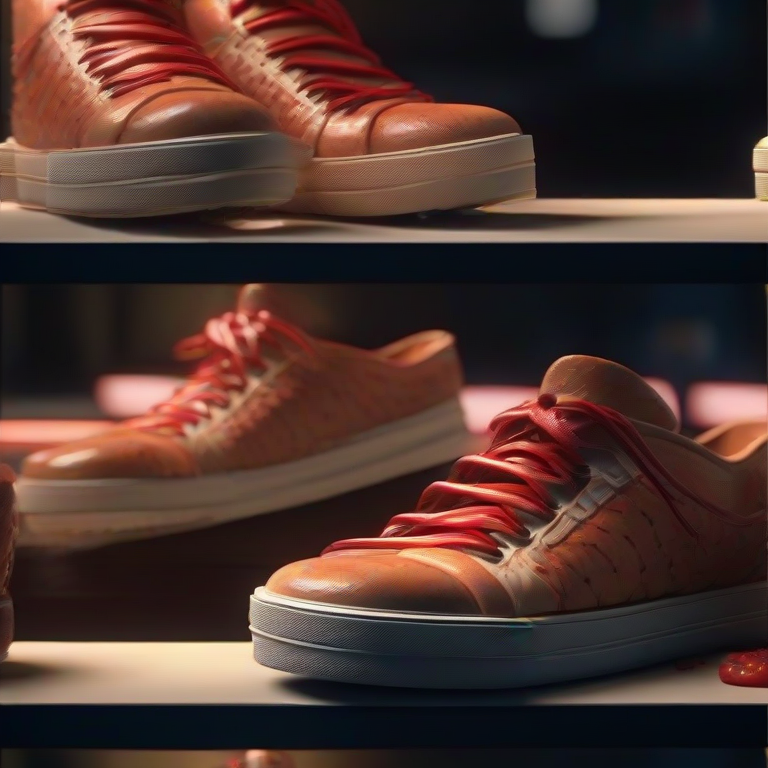

In [12]:
Image.fromarray(cu.create_image_grid(samples))

In [13]:
len(latents)

11

In [14]:
for l in latents: print(l.shape)

torch.Size([1, 4, 96, 96])
torch.Size([1, 4, 96, 96])
torch.Size([1, 4, 96, 96])
torch.Size([1, 4, 96, 96])
torch.Size([1, 4, 96, 96])
torch.Size([1, 4, 96, 96])
torch.Size([1, 4, 96, 96])
torch.Size([1, 4, 96, 96])
torch.Size([1, 4, 96, 96])
torch.Size([1, 4, 96, 96])
torch.Size([1, 4, 96, 96])


In [15]:
torch.save(latents, 'latents_from_jarvis.pth')

___

In [ ]:
assert False

In [13]:
model.model.no_control = False

In [14]:
samples, controls = cu.get_sdxl_sample(
    guidance=edges,
    ddim_steps=10,
    num_samples=num_samples,
    model=model,
    shape=[4, size // 8, size // 8],
    control_scale=0.95,
    prompt='cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed',
    n_prompt='lowres, bad anatomy, worst quality, low quality',
)

Global seed set to 1999158951


[CONTROL CORRECTION OF ControlledDiffusionEngine SCALED WITH 0.95]
Type of sampler:  <class 'sgm.modules.diffusionmodules.sampling.EulerEDMSampler'>


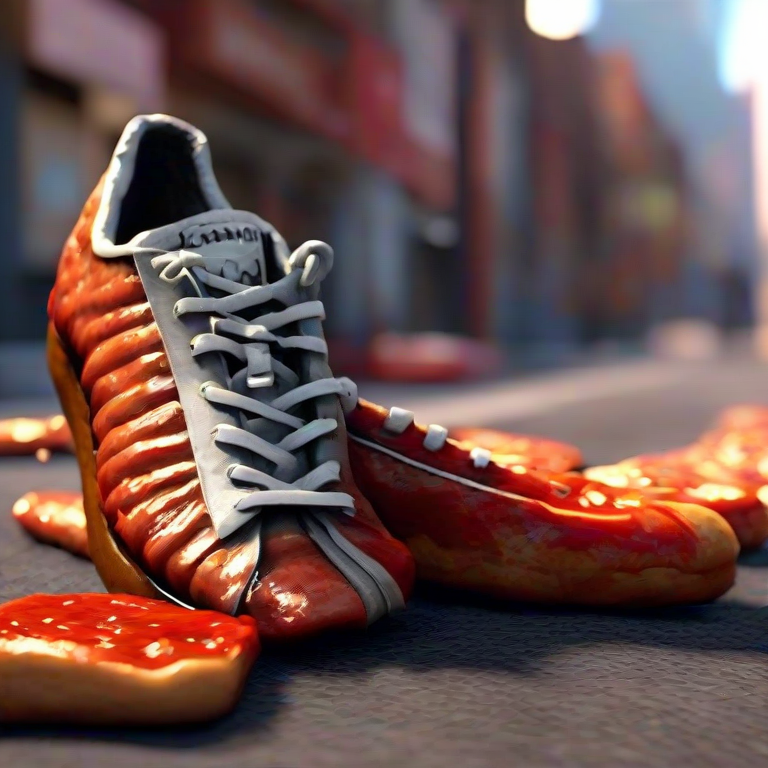

In [15]:
Image.fromarray(cu.create_image_grid(samples))